In [1]:
# import all relevant packages
import pandas as pd
from pandas import DataFrame
from pandas import read_csv

import numpy as np
from numpy.polynomial import Polynomial

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime

import scipy
from scipy import fftpack
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr

In [2]:
# create a custom date parse function for the data
custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%Y")

# create an easy variable for the .csv file path
filename_weekly = r'C:\Users\Giorgio\Desktop\Dissertation_Main\Disseration\Data\Source_Data\SRO_flux\ExtractedSubset\WeeklySubset.csv'
filename_daily = r'C:\Users\Giorgio\Desktop\Dissertation_Main\Disseration\Data\Source_Data\SRO_flux\ExtractedSubset\DailySubset.csv'

# load in the .csv using pandas.read_csv
df_weekly = read_csv(filename_weekly, header=0, parse_dates=[0], date_parser=custom_date_parser, index_col ='TIMESTAMP_START')
df_daily = read_csv(filename_daily, header=0, parse_dates=[0], date_parser= custom_date_parser, index_col = 'Date')

# inquire the data to check the data types
# df.info()

# show the first 13 values to ensure they are correct
# df.head(13)

# from the full subset only select the required values to make process time faster
df_w = df_weekly[['VPD_F','P_F','PPFD_IN','TA_F','SW_IN_F',
         'NEE_VUT_REF','GPP_DT_VUT_REF','RECO_DT_VUT_REF']]
df_d = df_daily[['VPD_F','P_F','PPFD_IN','TA_F','SW_IN_F',
         'NEE_VUT_REF','GPP_DT_VUT_REF','RECO_DT_VUT_REF']]

# show the first 13 values to ensure they are correct
#df_w.tail(5)
#df_d.head(5)
#df_w.describe()


# Set general parameters for all figures

plt.rcParams["figure.figsize"] = (40,15)
plt.rcParams.update({'font.size' : 30})


In [3]:
gppnp = np.array(df_d['GPP_DT_VUT_REF']) # Transform the df_d['GPP_DT_VUT_REF'] into a 1D numpy array

C:\Users\Giorgio\anaconda3\envs\geo_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 40.0)

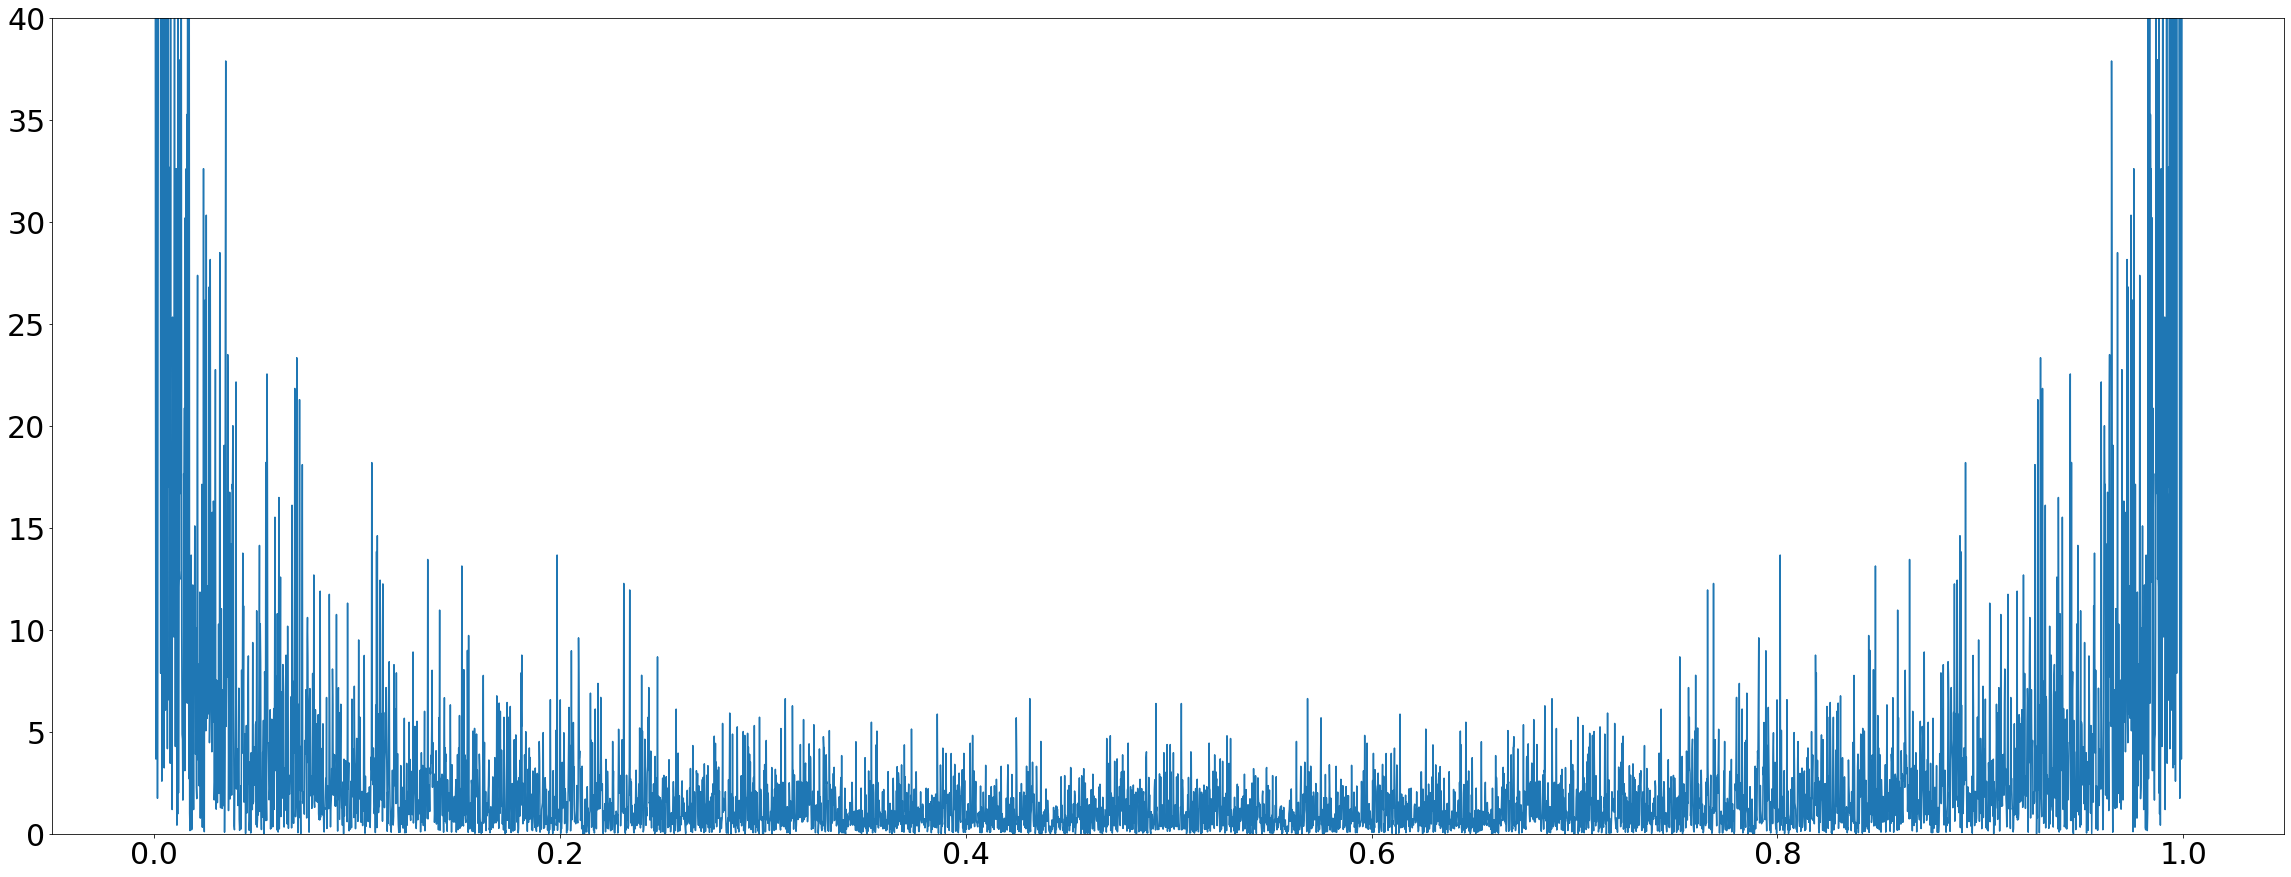

In [4]:
# Apply the Fast Fourier Transform


n = len(gppnp) # Determine the Length of the GPP array
fhat = np.fft.fft(gppnp, n) # Compute the FFT
PSD = fhat * np.conj(fhat) / n  # Compute the Power Spectral Densities
freq = (1/(1*n)) * np.arange(n) # create x-axis of the frequencies 

# clean the PSD less than a significance threshold and than inverse FFT 
indicies = PSD > 30 # exclude frequencis that have a PSD lower than 40
PSDClean = PSD * indicies # zero out all other freqiencies
fhat = indicies * fhat # zero out all smaller fourier coeffs in Y 
ffilt = np.fft.ifft(fhat) # find the inverse fourier 

fig, ax = plt.subplots()
plt.plot(freq, PSD)
ax.set_ylim(0,40)

In [5]:
## Define soomthing filters and plot them

gppsg = savgol_filter(gppnp, 81, 2) # Savistky-Golay on a 2nd order polynomial function

C:\Users\Giorgio\anaconda3\envs\geo_env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


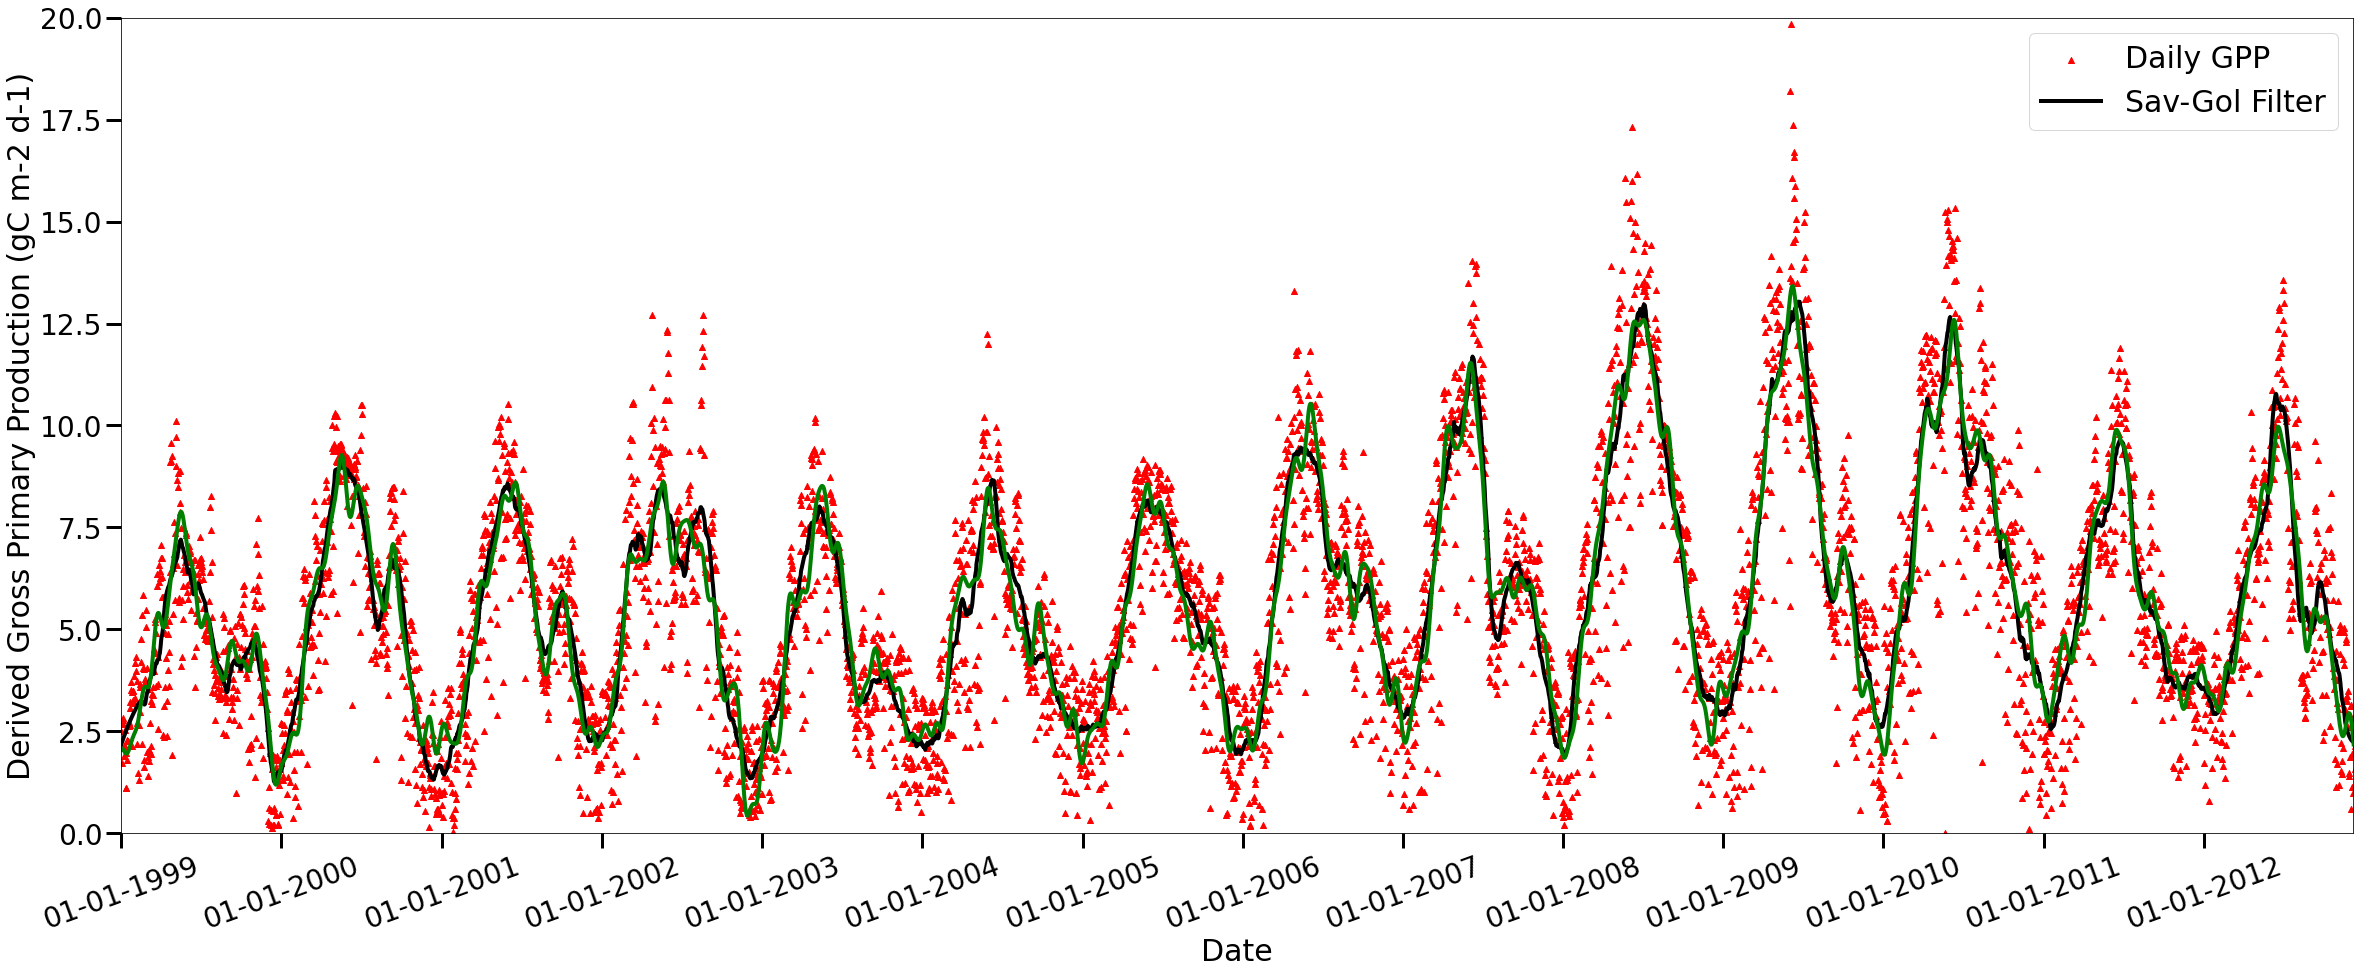

In [6]:
# plot daily derived day time gpp measurements
fig, gpp = plt.subplots()
gpp.scatter(df_d.index, df_d['GPP_DT_VUT_REF'],marker = '^', color = 'red', label = 'Daily GPP')

# x params
gpp.set_xlabel('Date')
gpp.set_xlim(date2num([df_w.index.min(), df_w.index.max()]))
gpp.tick_params('x', labelsize = 28, rotation=20, length = 15, width = 3)
gpp.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
gpp.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))

#y params
gpp.set_ylabel('Derived Gross Primary Production (gC m-2 d-1)')
gpp.set_ylim(0,20)
gpp.tick_params('y', labelsize = 28, length = 15, width = 3)

gpp.plot(df_d.index, gppsg, color = 'black', linewidth = 4, label = 'Sav-Gol Filter') # add sav-gol smooth curve

gpp.legend(loc = 'best')
gpp.plot(df_d.index, ffilt, color = 'green', linewidth = 4) # add Fast Fourier Transform


plt.savefig(r'C:\Users\Giorgio\Desktop\Dissertation_Main\Disseration\Figures\SRO_Val\Sro_gpp.jpeg', format = 'jpeg')

plt.show()




In [7]:
# Find the SOS and EOS using the Savitsky-Golay filtered values

df_d.insert(7,'GPP_SG_FILT', gppsg) ## Add the SG filtered values to the end of the DF array 
df_year = df_d.index.year # Extract the year from the DF index
df_d.insert(0, 'Year', df_year) # Add the year as the first column


In [8]:
# group the GPP values by the year and determine the max/min GPP value in that group

df_gs = df_d[['GPP_SG_FILT','Year' ]] # Group the GPP_SG_FILT by year 
df_g_max = df_gs.groupby('Year').max() # Determine the max value in each year
df_g_min = df_gs.groupby('Year').min() # Determine the min value in each year

df_amp_join = df_g_max.join(df_g_min, 'Year', lsuffix ='Year' ) #  join the max and min df 
df_amp_join.rename(columns = {'GPP_SG_FILTYear':'GPP_SG_FILT_MAX','GPP_SG_FILT': 'GPP_SG_FILT_MIN'}, inplace = True) # rename columns 

df_amp = df_amp_join # rename df 
df_amp['GPP_AMPLITUDE'] = df_amp['GPP_SG_FILT_MAX'] - df_amp['GPP_SG_FILT_MIN'] # calculate the amplitude of the yearly gpp change
df_amp['GPP_20th'] = df_amp['GPP_AMPLITUDE'].mul(.20) # determine the 20th percentile from the amplitude
df_amp['GPP_MINCORRECTED_20th'] = df_amp['GPP_SG_FILT_MIN'] + df_amp['GPP_20th'] # correct the 20th percentile for the min

#print(df_amp)

In [9]:
#df_amp

In [10]:
# Add the 5 new Phenology metrcis back into the original daily dataframe

df_d = df_d.join(df_amp, 'Year', how = 'left', lsuffix = 'Year') # join the two dataframes to include the max and 20th percentile

#print(df_d)

In [11]:
# check if GPP_SG_FILT is less then Min_Corrected_Annual_20th%

# define a function which checks the value of the filtered SG value against the annual min corrected 20th percentile.
# if the value is less than the 20th% than FALSE, if greater it is TRUE
def check_df(df_d):
    if (df_d['GPP_SG_FILT'] < (df_d['GPP_MINCORRECTED_20th'])):
        return 0
    elif (df_d['GPP_SG_FILT'] > (df_d['GPP_MINCORRECTED_20th'])):
        return 1
    else:
        return np.nan

df_d['BoolCheck'] = df_d.apply(check_df, axis=1) # apply the function to the dataframe

In [12]:
# create another column which checks if the values in 'BoolCheck' change between rows.
# if they do than True, if they dont than false
df_d['changes'] = df_d["BoolCheck"].shift() != df_d["BoolCheck"] 

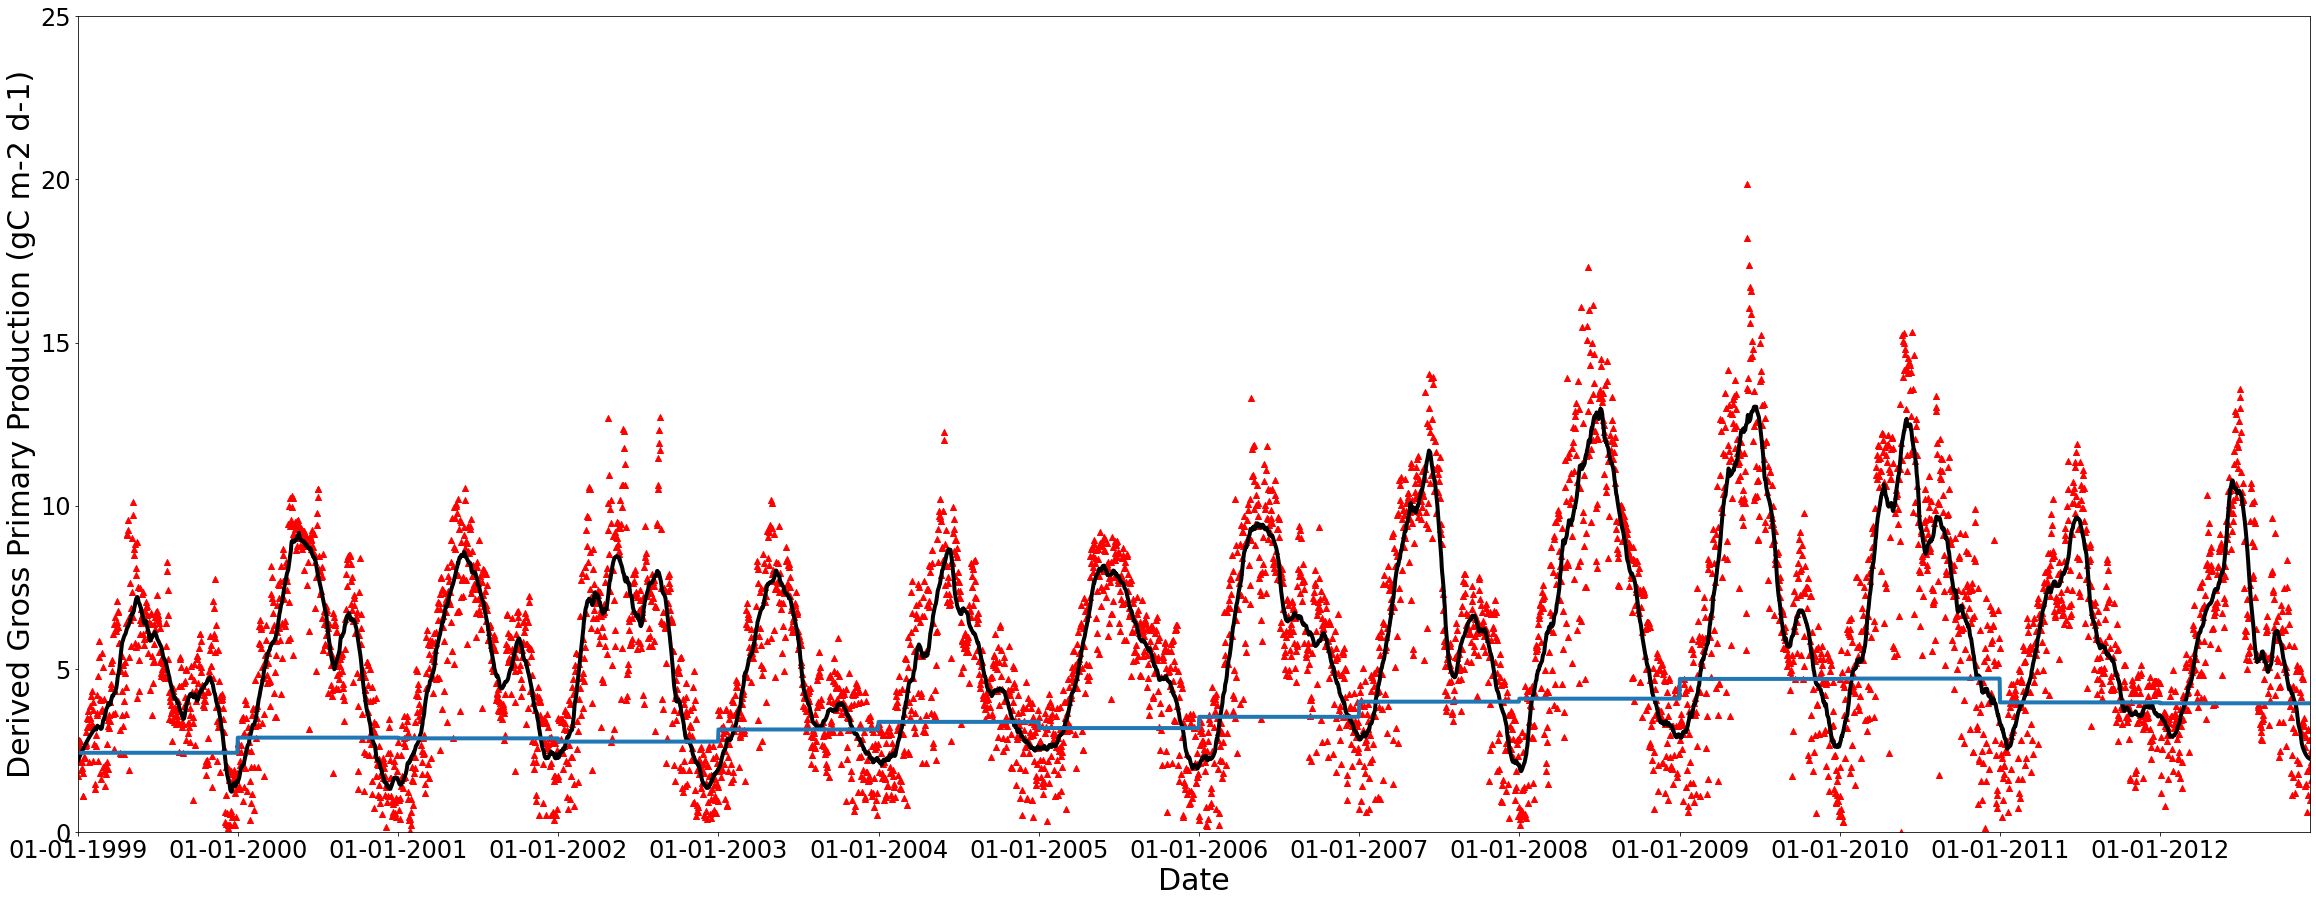

In [13]:
SC = df_d.loc[df_d['changes'] == True] # create a new df that only has values of change 

#print(SC) # print it

# plot daily derived day time gpp measurements
fig, gpp = plt.subplots()
gpp.scatter(df_d.index, df_d['GPP_DT_VUT_REF'],marker = '^', color = 'red') # Daily GPP values
gpp.plot(df_d.index, gppsg, color = 'black', linewidth = 4) # Savitsky-Golay Filter 
gpp.plot(df_d.index, df_d['GPP_MINCORRECTED_20th'], linewidth = 4) # Annual min corrected 20th percentile threshold


# x params
gpp.set_xlabel('Date')
gpp.set_xlim(date2num([df_w.index.min(), df_w.index.max()]))
gpp.tick_params('x', labelsize = 24)
gpp.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
gpp.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))

#y params
gpp.set_ylabel('Derived Gross Primary Production (gC m-2 d-1)')
gpp.set_ylim(0,25)
gpp.tick_params('y', labelsize = 24)


# add EOS vlines


#gpp.plot(df_d.index, ffilt, color = 'cyan', linewidth = 4) # add Fast Fourier Transform

plt.show()

# print(ffilt)
#print(gppsg, len(gppsg))
#print(df_d)

In [14]:
SOS2 = SC.loc[SC['BoolCheck'] == 1] # filter for all the instances where the change goes from false to true, SOS

EOS2 = SC.loc[SC['BoolCheck'] == 0] # Now filter for all the instances where the change is from true to false, EOS

SOS = SOS2[['GPP_SG_FILT','BoolCheck', 'changes']] # only select relevant columns
EOS1 = EOS2[['GPP_SG_FILT','BoolCheck', 'changes']] # only select relevant columns 

#SOS = SOS1.drop('2003-08-19') # Manually drop value that is not true start of season 
#EOS = EOS1.drop('2003-08-13') # Manually drop value that is not true end of season
EOS = EOS1.drop('1999-01-01') # Manually drop value that is not true end of season

SOS_join = SOS.reset_index()
EOS_join = EOS.reset_index()

Season = SOS_join.join(EOS_join, SOS_join.index, lsuffix = 'changes')
Season.rename(columns = {'Datechanges':'SOS_Date',
                         'GPP_SG_FILTchanges': 'SOS_GPP_SG_FILT',
                         'BoolCheckchanges': 'SOS_BoolCheck',
                         'changeschanges': 'SOS_changes',
                         'Date':'EOS_Date',
                         'GPP_SG_FILT': 'EOS_GPP_SG_FILT',
                         'changes':' EOS_changes'}, inplace = True)

Season_diff = Season[['SOS_Date','EOS_Date']]

Season_diff['DateDelta'] = Season_diff['EOS_Date'] - Season_diff['SOS_Date']


#Season_diff['SOS_julian'] = Season_diff['SOS_Date'].dt.to_julian_date()

#Season_diff['Length'] = Season_diff[]



#print(SOS_join)
#print(EOS_join)

print(Season_diff)

     SOS_Date   EOS_Date DateDelta
0  1999-01-10 1999-12-02  326 days
1  2000-01-29 2000-11-03  279 days
2  2001-02-18 2001-11-22  277 days
3  2002-01-19 2002-10-27  281 days
4  2003-02-06 2003-11-05  272 days
5  2004-02-26 2004-11-04  252 days
6  2005-02-27 2005-11-24  270 days
7  2006-02-19 2006-12-10  294 days
8  2007-02-08 2007-11-18  283 days
9  2008-01-31 2008-11-03  277 days
10 2009-02-16 2009-11-06  263 days
11 2010-01-28 2010-11-17  293 days
12 2011-02-22 2011-10-07  227 days
13 2012-02-27 2012-11-04  251 days


C:\Users\Giorgio\AppData\Local\Temp\ipykernel_35576\1173243235.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Season_diff['DateDelta'] = Season_diff['EOS_Date'] - Season_diff['SOS_Date']


In [16]:
Season_diff.to_csv(r'C:\Users\Giorgio\Desktop\Dissertation_Main\Disseration\Data\Processed_Data\SRO_Phenology.csv')
df_d.to_csv(r'C:\Users\Giorgio\Desktop\Dissertation_Main\Disseration\Data\Processed_Data\SRO_Data.csv')